In [19]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from numpy import linalg as LA
import time

In [20]:
imgName = "image1.jpg"
imgRgb = cv2.imread(imgName)
img = cv2.cvtColor(imgRgb, cv2.COLOR_BGR2GRAY)/255

sobelX = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobelY = np.transpose(sobelX)

In [21]:
def convolveSobel(conv_img, filterType, w = 3):
    n, m = conv_img.shape
    w = filterType.shape[0]
    conv_img = np.pad(conv_img,(int(w/2),int(w/2)),mode='constant')
    temp1=[]
    for i in range(n):
        temp=[]
        for j in range(m):
            k = conv_img[i:i+w, j:j+w]
            val = np.multiply(k, filterType)
            temp.append(np.sum(val))
        temp1.append(temp)
    
    return np.array(temp1)
Gx = convolveSobel(img, sobelX)
Gy = convolveSobel(img, sobelY)

Ixx=Gx**2
Iyy=Gy**2
Ixy=Gx*Gy

In [22]:
def ShiTomasi(img, Ixx, Iyy, Ixy, thr = 5, w = 3):
    n, m, _ = img.shape
    corners = np.zeros((n,m))
    wlen = int(w/2)
    for y in range(wlen, n-wlen):
        for x in range(wlen, m-wlen):
            H = np.zeros((2,2))
            Sxx=np.sum(Ixx[y-wlen:y+1+wlen, x-wlen:x+1+wlen])
            Syy=np.sum(Iyy[y-wlen:y+1+wlen, x-wlen:x+1+wlen])
            Sxy=np.sum(Ixy[y-wlen:y+1+wlen, x-wlen:x+1+wlen])
            H[0,0]=Sxx
            H[0,1]=Sxy
            H[1,0]=H[0,1]
            H[1,1]=Syy
            eigenValue, v= LA.eig(H)
            min_eigen_value = min(eigenValue[0],eigenValue[1])
            #print(min_eigen_value)
            if min_eigen_value>thr:
                corners[y, x] = min_eigen_value
    return corners 

def Harris(img, Ixx, Iyy, Ixy, thr = 5, w = 3, lambd = 0.04):
    n, m, _ = img.shape
    corners = np.zeros((n,m))
    wlen = int(w/2)
    for y in range(wlen, n-wlen):
        for x in range(wlen, m-wlen):
            Sxx=np.sum(Ixx[y-wlen:y+1+wlen, x-wlen:x+1+wlen])
            Syy=np.sum(Iyy[y-wlen:y+1+wlen, x-wlen:x+1+wlen])
            Sxy=np.sum(Ixy[y-wlen:y+1+wlen, x-wlen:x+1+wlen])

            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy
            r = det - lambd*(trace**2)
            if r > thr:
                corners[y, x] = r
    return corners
                
def NonMaxSuppression(img, corners, stride = 10):
    corner_img = img.copy()
    n, m, _ = corner_img.shape
    cornersNew = np.zeros(corners.shape)
    wlen = stride//2
    for y in range(wlen, n-wlen):
        for x in range(wlen, m-wlen):
            arr = np.array(corners[y:y+stride, x:x+stride])
            if(np.amax(arr) != 0):
                m_at = np.where(arr == np.amax(arr))
                if(m_at[0] == int(stride/2) and m_at[1] == int(stride/2)):
                    cornersNew[y, x] = corners[y+m_at[0], x+m_at[1]]
                    cv2.circle(corner_img,(x+m_at[1],y+m_at[0]),2,255,-1)
    return corner_img

---ShiTomasi: 15.466780424118042 seconds ---


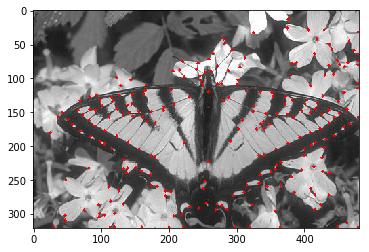

<Figure size 432x288 with 0 Axes>

In [23]:
start_time = time.time()
corners = ShiTomasi(imgRgb, Ixx, Iyy, Ixy, thr = 3)
corner_img = NonMaxSuppression(imgRgb, corners, stride = 10)
plt.imshow(corner_img, cmap="gray")
plt.figure()
cv2.imwrite("Image1_ShiTomasi.jpg", corner_img)
print("---ShiTomasi: %s seconds ---" % (time.time() - start_time))

---Harris: 6.574463129043579 seconds ---


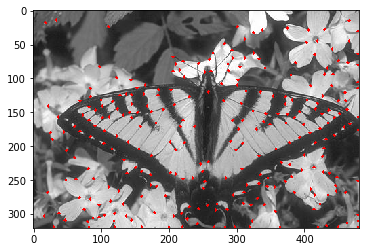

<Figure size 432x288 with 0 Axes>

In [24]:
start_time = time.time()
corners = Harris(imgRgb, Ixx, Iyy, Ixy)
corner_img = NonMaxSuppression(imgRgb, corners, stride = 15)
plt.imshow(corner_img, cmap="gray")
plt.figure()
cv2.imwrite("Image1_Harris.jpg", corner_img)
print("---Harris: %s seconds ---" % (time.time() - start_time))